In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from math import trunc
from matplotlib.transforms import ScaledTranslation
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

## 0. Specify FPs and open files

In [5]:
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')
INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'inputs')
plot_fp = os.path.join(OAK_FP, 'outputs', 'journal_plots')

# APN - GEOID - MEDIAN INCOME ----
# * Universe of SJ res parcels assigned to each CBG
sj_parcels_cbgs = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))
# * Income-stratified CBGs (from Pop-Estimates-Strata.ipynb)
cbg_income_2016_SJ = gpd.read_file(os.path.join(OUTPUT_FP, 'Strata', 'cbg-income-strata'))

# * San Jose AANC permit data
permits = pd.read_csv(os.path.join(OAK_FP, 'outputs/Permit-Matching/outputs/all_permits.csv'))

# * DETACHED ADUs ------
# * Original list
adu_list = pd.read_csv(os.path.join(INPUT_FP, 'IssuedADUs', 'Adu_Detach.csv'))
# * List with APNs
final_list = pd.read_csv(os.path.join(os.path.join(OUTPUT_FP, 'IssuedADUs', 'Adu_Detach.csv')), 
                        dtype={'APN': str})

## 1. Preprocessing

In [6]:
prop = sj_parcels_cbgs[['APN', 'GEOID']].merge(cbg_income_2016_SJ[['GEOID', 'median_inc', 'strata_inc']], on='GEOID')
res_count = prop['strata_inc'].value_counts().reset_index()
res_count = res_count.rename(columns={'index': 'strata_inc', 'strata_inc': 'count'})
res_count = res_count[res_count['strata_inc'] != 'IS_MISSING']

res_count['perc'] = res_count['strata_inc'].apply(lambda x: int(x.split('_')[1]))
res_count['decile'] = res_count['perc'].apply(lambda x: trunc(x/5))
res_count['quintile'] = res_count['perc'].apply(lambda x: trunc(x/10))

decile_count = res_count[['decile', 'count']].groupby('decile').agg(sum).reset_index()
quintile_count = res_count[['quintile', 'count']].groupby('quintile').agg(sum).reset_index()

In [7]:
final_list = final_list[final_list['APN'].notna()] # 3 parcels don't match to APN
final_list['DATE'] = pd.to_datetime(final_list['DATE'])
final_list['year'] = final_list['DATE'].dt.year

In [8]:
# drop around 4k parcels -- assuming not residential
m = permits[['APN_parcel', 'WORKDESC', 'issue_year']].merge(sj_parcels_cbgs[['APN', 'GEOID']], left_on='APN_parcel',
                                                       right_on='APN', how='inner')
m = m.merge(cbg_income_2016_SJ[['GEOID', 'median_inc', 'strata_inc']], on='GEOID', how='left')

# 50 APNs dropped -- assuming not residential
m_detach = final_list.merge(sj_parcels_cbgs[['APN', 'GEOID']], on='APN', how='inner')

m_detach = m_detach.merge(cbg_income_2016_SJ[['GEOID', 'median_inc', 'strata_inc']], on='GEOID', how='left')

In [9]:
m_detach = m_detach[m_detach['strata_inc'] != 'IS_MISSING']
m_detach['perc'] = m_detach['strata_inc'].apply(lambda x: int(x.split('_')[1]))
m_detach['decile'] = m_detach['perc'].apply(lambda x: trunc(x/5))
m_detach['quintile'] = m_detach['perc'].apply(lambda x: trunc(x/10))

In [10]:
decile_mapping = {}
quintile_mapping = {}
for i in range(50):
    decile_mapping[i] = trunc(i/5)
    quintile_mapping[i] = trunc(i/10)

## 2. Plots

Define helper functions

In [11]:
def process_permits(m_detach, split):
    s = m_detach[(m_detach['year'] >= 2015) & ((m_detach['year'] <= 2020))][split].value_counts().reset_index().rename(columns={split: 'n_permits', 'index': split})
    if split == 'quintile':
        s = s.merge(quintile_count, on=split)
    elif split == 'decile':
        s = s.merge(decile_count, on=split)
    s['proportion'] = s['n_permits']/s['count']
    
    return s

In [12]:
def process_results(results_df, mapping, split):
    results_df = results_df[~results_df['bin'].str.contains('MISSING')]
    results_df['bin_n'] = results_df['bin'].apply(lambda x: int(x.split('_')[1].split('-')[0]))
    results_df['bin1'] = results_df['bin_n'].map(mapping)
    agg_df = results_df[['bin1', 't', 'tot_var']].groupby(['bin1']).agg(sum).reset_index()
    
    diff_df = pd.DataFrame(columns=['bin1', 'diff', 'var'])
    for b in agg_df['bin1'].unique():
        subset = agg_df[agg_df['bin1'] == b]
        d = subset['t'].values[0]
        var = subset['tot_var'].values[0]
        diff_df.loc[len(diff_df)] = [b, d, var]

    diff_df['ci_95'] = np.sqrt(diff_df['var'])*1.96
    if split == 'quintile':
        diff_df = diff_df.merge(quintile_count, left_on='bin1', right_on=split)
    elif split == 'decile':
        diff_df = diff_df.merge(decile_count, left_on='bin1', right_on=split)
#     diff_df = diff_df.merge(quintile_count, left_on='bin1', right_on='quintile')
    diff_df['diff_prop'] = diff_df['diff']/diff_df['count']
    diff_df['ci_95_prop'] = diff_df['ci_95']/diff_df['count']
    
    return diff_df

In [13]:
def process_results_bootstrap(results_df, mapping, split):
    results_df = results_df[~results_df['bin'].str.contains('MISSING')]
    bootstrap_inc = []
    for i in range(1000):
        bootstrap_inc += [i]*150
    results_df['bootstrap_inc'] = bootstrap_inc
    results_df['bin_n'] = results_df['bin'].apply(lambda x: int(x.split('_')[1].split('-')[0]))
    results_df['bin1'] = results_df['bin_n'].map(mapping)
    agg_df = results_df[['bootstrap_inc', 'bin1', 't']].groupby(['bootstrap_inc', 'bin1']).agg(sum).reset_index()
    
    diff_df = pd.DataFrame(columns=['bin1', 'diff', 'ci_95'])
    for b in agg_df['bin1'].unique():
        mean, ci = two_sided_test(agg_df[agg_df['bin1'] == b]['t'].tolist(), 0.05)
        diff_df.loc[len(diff_df)] = [b, mean, mean-ci[0]]

    if split == 'quintile':
        diff_df = diff_df.merge(quintile_count, left_on='bin1', right_on=split)
    elif split == 'decile':
        diff_df = diff_df.merge(decile_count, left_on='bin1', right_on=split)
#     diff_df = diff_df.merge(quintile_count, left_on='bin1', right_on='quintile')
    diff_df['diff_prop'] = diff_df['diff']/diff_df['count']
    diff_df['ci_95_prop'] = diff_df['ci_95']/diff_df['count']
    
    return diff_df

In [14]:
# this is deprecated
def plot_bar_line(s, diff_df, how, err_label, split, savefig=None):
    if how == 'count':
        y_col = 'n_permits'
        y_label = 'Count'
        plt.errorbar(diff_df['bin1'], diff_df['diff'], yerr=diff_df['ci_95'], label=err_label)
    elif how == 'proportion':
        y_col = 'proportion'
        y_label = 'Density (Count ÷ # Parcels)'
        plt.errorbar(diff_df['bin1'], diff_df['diff_prop'], yerr=diff_df['ci_95_prop'], label=err_label)
    plt.bar(s[split], s[y_col], color='orange', label='Detached ADU Permits Issued')
    plt.xlabel('CBG Median Income Quintile')
    plt.legend(bbox_to_anchor=(1.3, 1.05))
    plt.ylabel(y_label)
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()

In [15]:
def plot_bar_line2(s, diff_df, diff_df_bootstrap, how, split, savefig=None):
    fig, ax = plt.subplots()
    trans1 = ax.transData + ScaledTranslation(-5/72, 0, fig.dpi_scale_trans)
    trans2 = ax.transData + ScaledTranslation(+5/72, 0, fig.dpi_scale_trans)
    if how == 'count':
        y_col = 'n_permits'
        y_label = 'Count'
        ax.errorbar(diff_df['bin1'], diff_df['diff'], yerr=diff_df['ci_95'], label='Population Estimate', 
                    marker="o", linestyle="none", transform=trans1)
        ax.errorbar(diff_df_bootstrap['bin1'], diff_df_bootstrap['diff'], yerr=diff_df_bootstrap['ci_95'], 
                    label='Bootstrap', marker="o", linestyle="none", transform=trans2)
    elif how == 'proportion':
        y_col = 'proportion'
        y_label = 'Construction per Parcel'
        ax.errorbar(diff_df['bin1'], diff_df['diff_prop'], yerr=diff_df['ci_95_prop'], label='Population Estimate',
                   marker="o", linestyle="none", transform=trans1)
        ax.errorbar(diff_df_bootstrap['bin1'], diff_df_bootstrap['diff_prop'], yerr=diff_df_bootstrap['ci_95_prop'], 
                    label='Bootstrap', marker="o", linestyle="none", transform=trans2)
    ax.bar(s[split], s[y_col], color='orange', label='Detached ADU Permits Issued')
    plt.xlabel('CBG Median Income Quintile')
    plt.legend(bbox_to_anchor=(1.5, 1.05), fontsize = 15)
#     plt.legend(bbox_to_anchor=(1.2, 1.0))
    plt.ylabel(y_label)
    if savefig is not None:
        plt.savefig(savefig, bbox_inches='tight')
    plt.show()

In [16]:
def two_sided_test(l, p):
    l.sort()
    ci = [l[int(p/2*len(l))], l[len(l) - int(p/2*len(l))]]
    mean = np.mean(l)
    return mean, ci

In [17]:
def run_twin_plot(fp, col, m_detach, how, split, savefig=None):
    s = m_detach[(m_detach['year'] >= 2015) & ((m_detach['year'] <= 2020))][split].value_counts().reset_index().rename(columns={split: 'n_permits', 'index': split})
    if split == 'quintile':
        s = s.merge(quintile_count, on=split)
        mapping = quintile_mapping
    elif split == 'decile':
        s = s.merge(decile_count, on=split)
        mapping = decile_mapping
    s['proportion'] = s['n_permits']/s[split]
    
    s = process_permits(m_detach, split)
    results_df = pd.read_csv(os.path.join(fp, 'batch3', f'bin_estimates_{col}.csv'))
    results_df_bootstrap = pd.read_csv(os.path.join(fp, 'batch3', f'bin_estimates_boostrap_{col}.csv'))
    
    diff_df = process_results(results_df, mapping, split)
    diff_df_bootstrap = process_results_bootstrap(results_df_bootstrap, mapping, split)
    
    plot_bar_line2(s, diff_df, diff_df_bootstrap, how, split, savefig)

In [18]:
fp = '/oak/stanford/groups/deho/building_compliance/outputs/Population-Estimates/final/'

#### i. Pure construction events

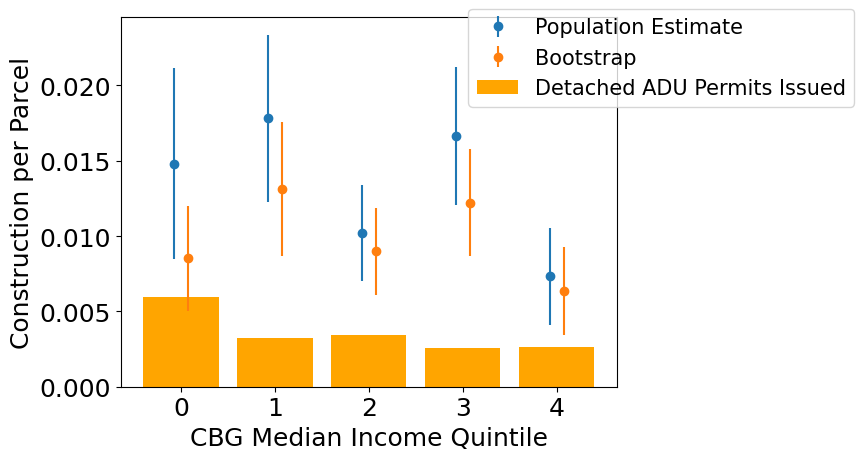

In [59]:
run_twin_plot(fp, 'construction', m_detach, 'proportion', 'quintile', os.path.join(plot_fp, 'q3_construction.pdf'))

#### ii. All changes

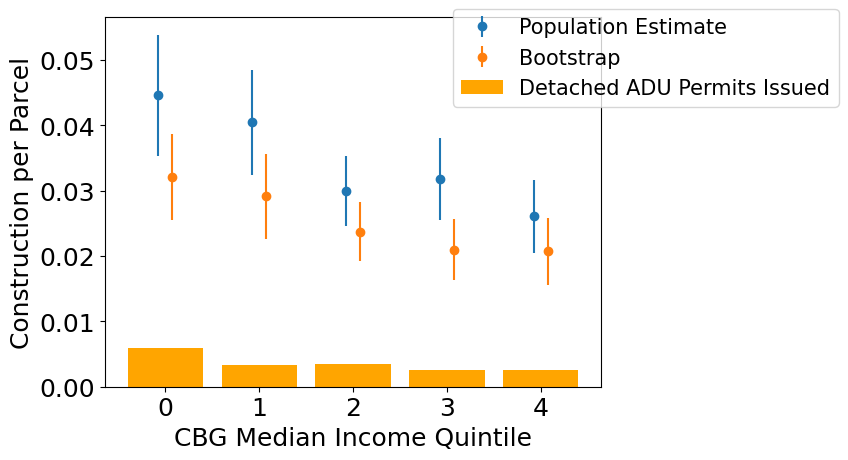

In [60]:
run_twin_plot(fp, 'change', m_detach, 'proportion', 'quintile', os.path.join(plot_fp, 'q3_change.pdf'))

#### iii. Change area thresholding

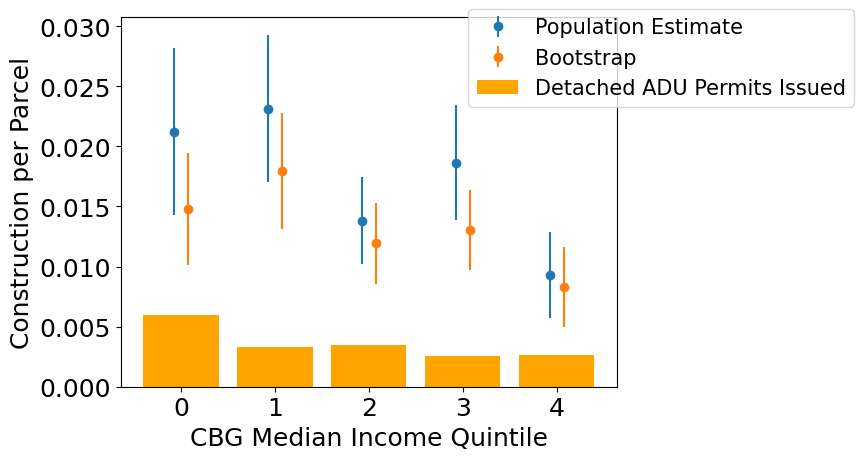

In [61]:
run_twin_plot(fp, 'change_area1.2', m_detach, 'proportion', 'quintile', os.path.join(plot_fp, 'q3_change1.2.pdf'))